# Capstone Project:
# Predictions of New Orleans Service Requests Processing Periods
##### Nadia Buksa, July 2022. BrainStation

---
## Business Problem

**Predict the number of days required to satisfy a service request.**

---

<center><h1> Part 3 </h1></center>

<center><h3> Modeling, Analysis, and Conclusions </h3></center>

<h5>Goal:</h5> 

***Build predicting models, evaluate them to determine the best model, and find a solution to the business problem***

---

# Table of Contents

1. [Data Acquisition](#Data-Acquisition) <br><br>
4. [Data Preparation](#Data-Preparation) <br><br>
6. [Linear Models](#Linear-Models) <br>
    - [Scale the data](#Scale-the-data)
    - [Model 1: Linear Regression](#Model-1:-Linear-Regression)
    - [Model 2: Decision Trees Regressor](#Model-2:-Decision-Trees-Regressor) <br><br>
7. [Categorical Models](#Categorical-Models) <br>
    - [Feature Engineering](#Feature-Engineering) 
    - [Model 3: Logistic Regression](#Model-3:-Logistic-Regression) 
    - [Model 4: K-Nearest Neighbors](#Model-4:-K-Nearest-Neighbors) 
    - [Model 5: Decision Trees Classifier](#Model-5:-Decision-Trees-Classifier) <br><br>
8. [Determine the best model](#Determine-the-best-model) <br><br>
9. [Set variance threshold](#Set-variance-threshold) <br><br>
9. [Multicolinearity check](#Multicolinearity-check)<br><br>
11.[Clustering](#Clustering) <br><br>
10.[SMOTE](#SMOTE) <br>
    - [Prepare Data](#Prepare-Data)
    - [Downsampling](#Downsampling)
    - [Upsampling](#Upsampling) <br><br> 
12. [Final Scoring](#Final-Scoring)<br><br>
13. [Inspect Outliers](#Inspect-Outliers)<br><br>
14. [K Means Clustering](#K-Means-Clustering)

In [500]:
# Basics
import pandas as pd
import numpy as np

# Visuals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Stats
import statsmodels.api as sm
from scipy import stats

# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Scalers
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# Model evaluations tools:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score


# Data Acquisition

In [501]:
df = pd.read_csv('end_of_part_two_dummies.csv', low_memory=False)
df.head()

,case_closed,lat,lon,processing_period_days,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,...,type_Trash/Recycling,type_unknown,tags_Inspected,tags_Pending,tags_Referred,tags_Referred to Code Enforcement,tags_Resolved,tags_Reviewed,tags_other,tags_unknown
0,0,0.000000,0.000000,NaN,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,29.943975,-90.065412,NaN,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,29.979937,-90.073291,91.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,1,29.968404,-90.034680,91.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,1,29.974061,-90.068478,91.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [502]:
df.shape

(522922, 74)

In [503]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522922 entries, 0 to 522921
Data columns (total 74 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   case_closed                                       522922 non-null  int64  
 1   lat                                               522922 non-null  float64
 2   lon                                               522922 non-null  float64
 3   processing_period_days                            454113 non-null  float64
 4   year_2013                                         522922 non-null  int64  
 5   year_2014                                         522922 non-null  int64  
 6   year_2015                                         522922 non-null  int64  
 7   year_2016                                         522922 non-null  int64  
 8   year_2017                                         522922 non-null  int64  
 9   year

In [504]:
# Show data metrics

print("The new dataset contains:")
print(f"{df.shape[0]} rows and {df.shape[1]} columns.")
print(f"{df.isna().sum().sum()} null values, that is {round(df.isna().sum().sum()/(df.isna().sum().sum()+df.notnull().sum().sum())*100, 2)}% of all dataset cels (not rows)")
print(f"{df.duplicated().sum()} duplicated rows")

The new dataset contains:
522922 rows and 74 columns.
68809 null values, that is 0.18% of all dataset cels (not rows)
0 duplicated rows


In [505]:
# Show % of missing values and where they are

na_table = df.isna().mean().mul(100).round(2)
na_table[na_table > 0]

processing_period_days    13.16
dtype: float64

---
# Data Preparation

   [1.](#Data-Preparation---Step-1:-Create-a-Backup-Copy-of-the-Working-Data-Set) Create a backup copy of the working data set<br>
   [2.](#Data-Preparation---Step-2:-Remove-Data-Associated-with-Pending-Requests) To predict the number of days it takes to resolve a service request, I will be working with closed cases only. In order to not confuse the predicting models, **remove data that is associated with pending requests**<br>
   [3.](#Data-Preparation---Step-3:-Inspect-outliers) Inspect outliers <br>
   [4.](#Data-Preparation---Step-4:-Establish-Target-and-Dependent-Variable) Establish Target and Dependent Variables<br>
   [5.](#Data-Preparation---Step-5:-Check-for-Variable-Independence/No-Multicollinearity) Check for Variable Independence/No Multicollinearity <br>
   [6.](#Data-Preparation---Step-6:-Write-functions-for-frequently-repeated-steps:) Write functions for frequently repeated steps:<br>
   [7.](#Data-Preparation---Step-7:-Split-the-Data-into-Train/Validation/Test-sets) Train/Validation/Test split the data

---

## Data Preparation - Step 1: Create a Backup Copy of the Working Data Set

In [506]:
backup = df.copy()

## Data Preparation - Step 2: Remove Data Associated with Pending Requests

We know that 'Pending' requests have null values in `date_closed`, therefore `processing_period_days` are null as well. 'Pending' requests make up 13% of all records.

For this model we will be working with closed cases only. Remove all 'Pending' cases from the working data set.

In [507]:
# Remove 'Pending' cases

# Remnider that case_closed = 0 stands for Pending case

to_drop = df[df['case_closed'] == 0].index
df.drop(index=to_drop, inplace=True)

In [508]:
# To select variables that are associated with pending requests, show all columns

df.columns

Index(['case_closed', 'lat', 'lon', 'processing_period_days', 'year_2013',
       'year_2014', 'year_2015', 'year_2016', 'year_2017', 'year_2018',
       'year_2019', 'year_2020', 'year_2021', 'year_2022', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'dist_B', 'dist_C',
       'dist_D', 'dist_E', 'dist_unknown', 'agency_Bureau of Treasury',
       'agency_Department of Code Enforcement',
       'agency_Department of Parks & Parkway',
       'agency_Department of Public Works', 'agency_Department of Sanitation',
       'agency_Emergency Medical Services',
       'agency_Executive Office of the Mayor',
       'agency_Ground Transportation Bureau', 'agency_Health Department',
       'agency_Mosquito, Termite & Rodent Control Board',
       'agency_Office of Police Secondary Employment',
       'agency_Safety and P

**Select records that are associated with pending requests:**

- `case_closed` - since all cases in the working dataset will be closed, this columns brings no value
- `tags_pending` - assuming that only pending cases would have this tag

In [509]:
# Remove selected columns

df.drop(columns = ['case_closed', 'tags_Pending'], inplace = True)

In [510]:
# By removing all pending cases, 
# I should have gotten rid of all null values in the target variable processing_period_days
# Check if that's true

df['processing_period_days'].isna().sum()

0

## Data Preparation - Step 3:  Inspect outliers

In [511]:
# Save the outliers to a dataframe
period_table = df['processing_period_days'].value_counts().to_frame().reset_index()
period_table['number_of_instances'] = period_table['index']
period_table.drop(columns='index', inplace=True)

In [512]:
# show the outliers
period_table.sort_values(by='number_of_instances', ascending=False)

,processing_period_days,number_of_instances
2544,1,3515.0
2491,1,3208.0
2470,1,3143.0
2541,1,3095.0
2567,1,3086.0
...,...,...
5,12979,4.0
4,13863,3.0
3,14475,2.0
1,20388,1.0


In [513]:
np.percentile(a=df['processing_period_days'].dropna(), q=range(90, 100))

array([ 353.,  394.,  442.,  497.,  562.,  650.,  880., 1256., 1789.,
       2358.])

<AxesSubplot:title={'center':'Distribution of processing_period_days by length'}, xlabel='processing_period_days', ylabel='Number of processed requests'>

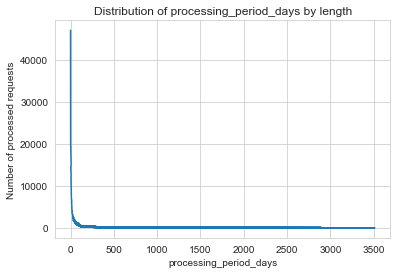

In [514]:
# illustrate the outliers
df['processing_period_days'].value_counts().plot(xlabel = 'processing_period_days',
                                                 ylabel = 'Number of processed requests',
                                                 title = 'Distribution of processing_period_days by length')

In [515]:
period_table[period_table['processing_period_days'] > 366]

,processing_period_days,number_of_instances
0,46985,0.0
1,20388,1.0
2,14796,7.0
3,14475,2.0
4,13863,3.0
...,...,...
153,371,266.0
154,371,230.0
155,369,127.0
156,368,167.0


In [516]:
# Create a copy where I will remove the outliers from, 
# As I expect to be using a datset that contains the outliers in the later parts of the analysis

df_under_one_year = df.copy()

In [517]:
# Remove all records that have 'processsing_period' over a year

to_drop = df_under_one_year[df_under_one_year['processing_period_days'] > 365].index
df_under_one_year.drop(index=to_drop, inplace=True)

I wanted to use MinMax scaler to address my skewed data distribution, and also wanted to use Robust scaler to address all the outliers in the data. As a result, I have manually removed the outliers, and used MinMax scaler. This approach got me the best results.

## Data Preparation - Step 4: Establish Target and Dependent Variable

In [518]:
y_underyr = df_under_one_year['processing_period_days']
X_underyr = df_under_one_year.drop(columns=['processing_period_days'])

In [519]:
# # Make sure X has no duplicates and no categorical variables
# X_underyr.duplicated().sum()

# # Remove duplicates from X_underyr
# X_underyr.drop_duplicates(inplace = True)

# # Check
# X_underyr.duplicated().sum()

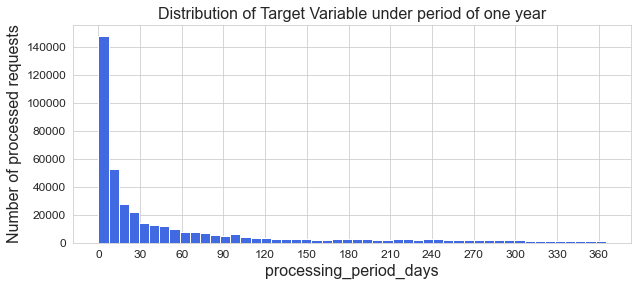

<Figure size 432x288 with 0 Axes>

In [520]:
# From the EDA we know, that y is not normally distributed
# Show hist

plt.figure(figsize = (10,4))
plt.hist(y_underyr, bins = 50, color = 'royalblue')
plt.xlabel('processing_period_days', fontsize = 16)
plt.xticks(range(0, 365, 30), fontsize = 12)
plt.ylabel('Number of processed requests', fontsize = 16)
plt.yticks(fontsize = 12)
plt.title('Distribution of Target Variable under period of one year', fontsize = 16)
plt.show()
plt.savefig("Distribution of Target Variable_underyr.png", dpi=300)

## Data Preparation - Step-5: Check for Variable Independence/No Multicollinearity

In [521]:
# Check for collinearity: 

X_corr = X_underyr.corr()

In [522]:
corr_table = ((X_corr >= 0.7) & (X_corr < 1)).sum(axis=0).sort_values() # sum by rows
correlated_vars = corr_table[corr_table > 0].index
X_corr = X_corr[correlated_vars]
correlations = X_corr.filter(items=correlated_vars, axis=0)
correlations = correlations.mask(correlations == 1)

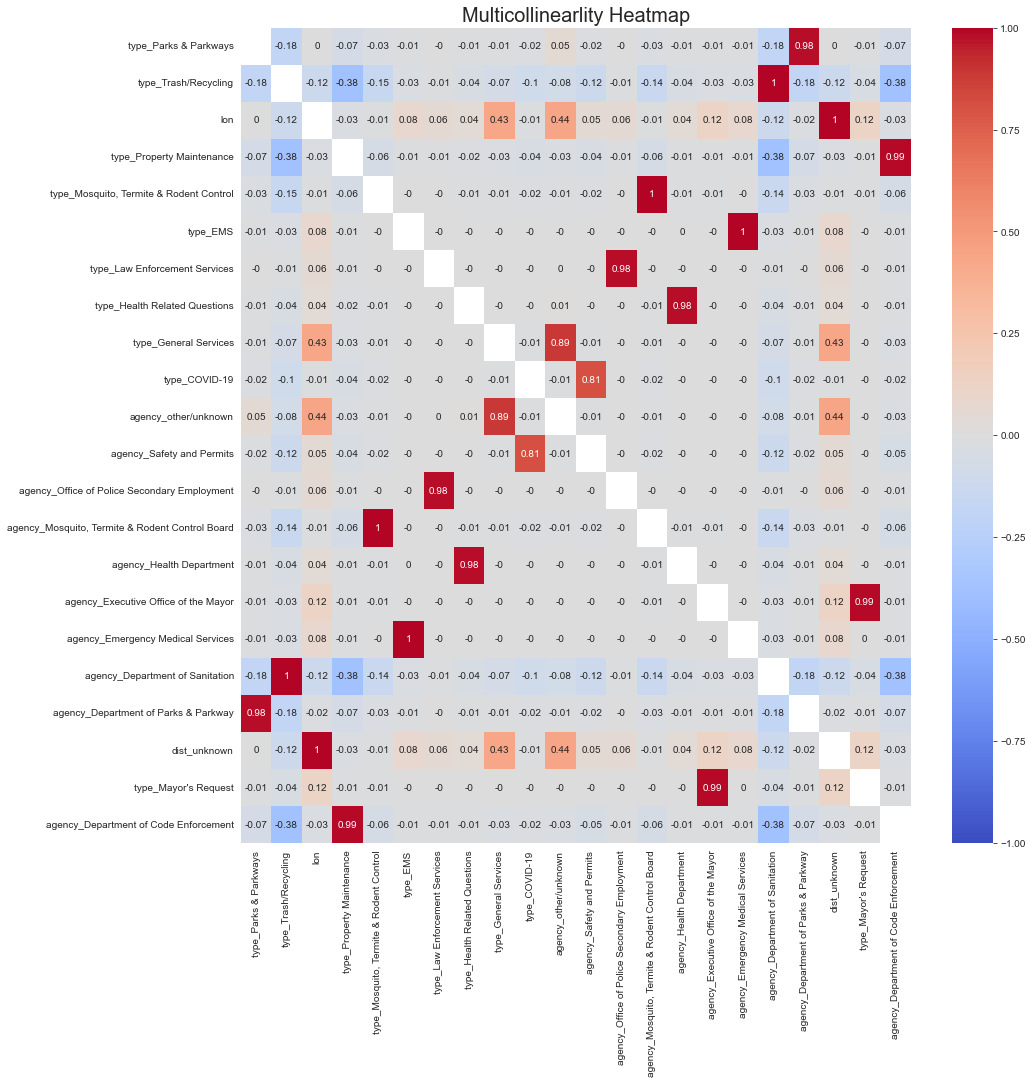

In [523]:
plt.figure(figsize=(15,15))
sns.heatmap(round(correlations,2), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm')
plt.title('Multicollinearlity Heatmap', fontsize = 20)
plt.show()

Observation: there is strong correlation between `type` and `agency`. Remove `agency`.

In [524]:
# agencies and types are strongly correlated. Remove all agencies and leave types:

agencies_cols = X_underyr.columns[X_underyr.columns.str.startswith("agency_")]
X_underyr.drop(columns = agencies_cols, inplace=True)

In [525]:
# Check for collinearity: 

X_corr = X_underyr.corr()

In [526]:
# This timelower the correlation threshold from 0.7 to 0.5

corr_table = ((X_corr >= 0.5) & (X_corr < 1)).sum(axis=0).sort_values() # sum by rows
correlated_vars = corr_table[corr_table > 0].index
X_corr = X_corr[correlated_vars]
correlations = X_corr.filter(items=correlated_vars, axis=0)
correlations = correlations.mask(correlations == 1)

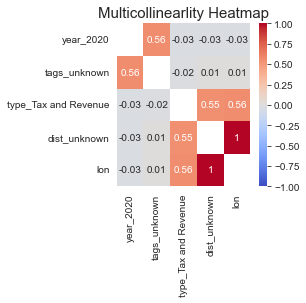

In [527]:
plt.figure(figsize=(3,3))
sns.heatmap(round(correlations,2), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm')
plt.title('Multicollinearlity Heatmap', fontsize = 15)
plt.show()

In [528]:
X_underyr.drop(columns = ['dist_unknown', 'type_Tax and Revenue', 'tags_unknown'], inplace = True)

In [529]:
X_underyr.columns

Index(['lat', 'lon', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'year_2018', 'year_2019', 'year_2020', 'year_2021',
       'year_2022', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'dist_B', 'dist_C', 'dist_D', 'dist_E', 'type_COVID-19',
       'type_EMS', 'type_General Services', 'type_Hard Rock Hotel Collapse',
       'type_Health Related Questions', 'type_Law Enforcement Services',
       'type_Mayor's Request', 'type_Mosquito, Termite & Rodent Control',
       'type_Parks & Parkways', 'type_Property Maintenance',
       'type_Roads/Drainage', 'type_Safety & Permits', 'type_Taxi Issues',
       'type_Traffic Signals/Signs/Striping/Streetlights',
       'type_Trash/Recycling', 'type_unknown', 'tags_Inspected',
       'tags_Referred', 'tags_Referred to Code Enforcement ', 'tags_Res

In [530]:
X_underyr.shape

(410138, 55)

## Data Preparation - Step 6: Write functions for frequently repeated steps:
- train-validation-test split
- scaling
- model evaluation (on validation set)


In [532]:
from sklearn.model_selection import train_test_split

# Create function that does the split
def train_val_test_split(X, y, train_size=0.7):
    # First, split the datat into train and test
    X_train, X_remainder, y_train, y_remainder = train_test_split(X, y,
                                                                train_size = train_size,
                                                                random_state = 404)
    # Splitting the remainder in two chunks
    X_test, X_val, y_test, y_val = train_test_split(X_remainder,
                                                  y_remainder,
                                                  test_size = 0.5,
                                                  random_state = 404)
    print(f"Train: {round(X_train.shape[0]/X.shape[0]*100)}%")
    print(f"Validation: {round(X_val.shape[0]/X.shape[0]*100)}%")
    print(f"Test: {round(X_test.shape[0]/X.shape[0]*100)}%")

    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_data(scaler, train, *datasets):
    # first, fit the data on the training set (and transfrom immediately)
    train = scaler.fit_transform(train)
    results = [train]
    # all other datasets, transform using the fitted scaler
    for dataset in datasets:
        results.append(scaler.transform(dataset))
    return results

def model_score(model, X_train, X_val, y_train, y_val):
    print(f"Train Score {model.score(X_train, y_train):.3%}")
    print(f"Validation Score {model.score(X_val, y_val):.3%}")

## Data Preparation - Step 7: Split the Data into Train/Validation/Test sets

This is how I want to split the data:

|   **Train**   |   **Validation**   |   **Test**   |
|---------------|--------------------|--------------|
|      70%      |<center>15%</center>|      15%     |

And this is why:

My data is not normally distributed, and has a lot of outliers. For this reason, I decided to follow the common practice of splitting the data in 70/30 ratio. I would not recommend having validation and/or test sets less than 15% each.

In [533]:
X_train_underyr, X_val_underyr, X_test_underyr, y_train_underyr, y_val_underyr, y_test_underyr = train_val_test_split(X_underyr, y_underyr)

Train: 70%
Validation: 15%
Test: 15%


**<center> End of Data Preparation </center>**

---


# Linear Models

## Scale the data

In [534]:
# Use minmax scaler because I already removed the outliers

mm_scaler = MinMaxScaler()
X_train_underyr_mm, X_val_underyr_mm, X_test_underyr_mm = scale_data(robust_scaler,
                                                                     X_train_underyr,
                                                                     X_val_underyr,
                                                                     X_test_underyr)

In [535]:
# Check

print(X_train_underyr_mm.shape == X_train_underyr.shape)
print(X_val_underyr_mm.shape == X_val_underyr.shape)
print(X_test_underyr_mm.shape == X_test_underyr.shape)

True
True
True


#### Check relationship between each column and the target variable

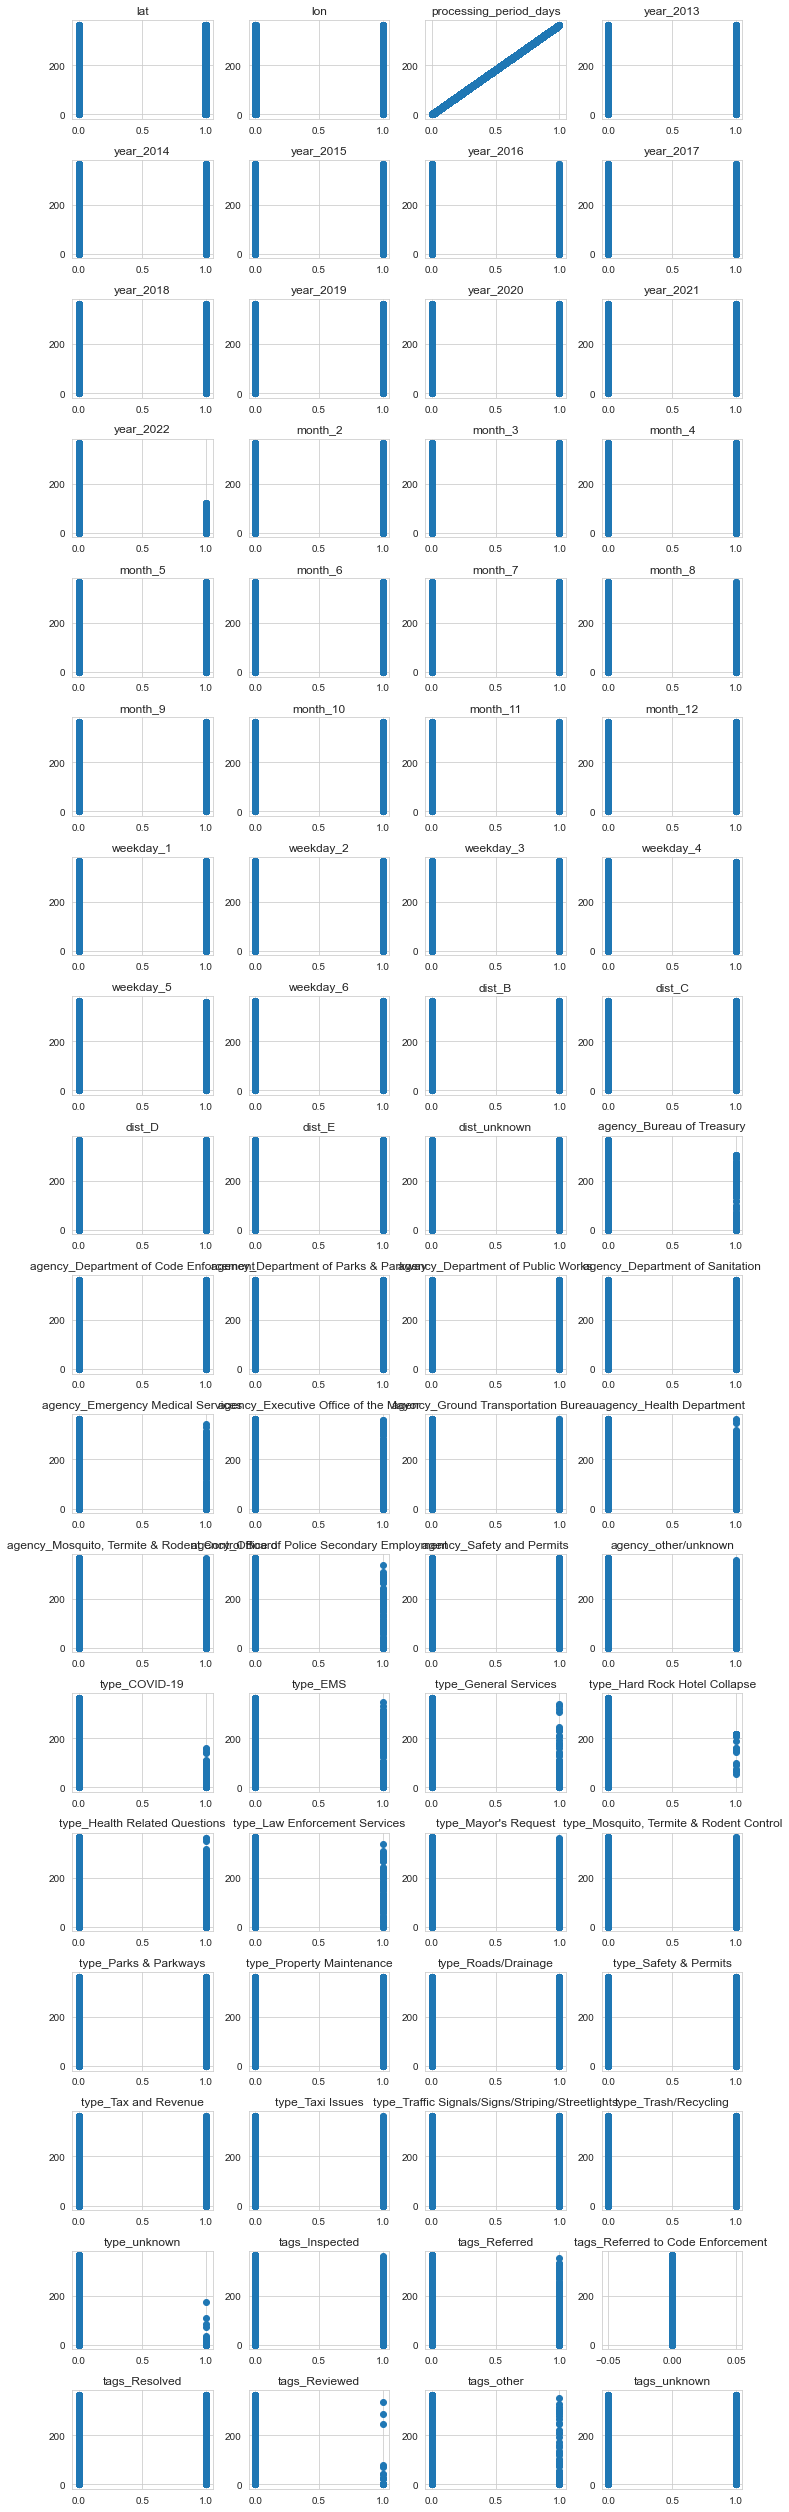

In [536]:
# Loop over the columns and plot the relationship between each column and the target
plt.subplots(18,4, figsize=(10,35))

count = 1

for col in X_linearity_test .columns:
    plt.subplot(18,4,count)
    plt.scatter(X_linearity_test [col],y_underyr)
    plt.title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

Linearity does not mean that the predictor variables have to be continuous; it means the target variable is a linear function of whatever values the predictor variables happen to take on.

Because most of the categories only have two possible values, we may not observe a linear relationship on the graph above. 

---
## Model 1: Linear Regression
---

In [537]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(X_train_underyr_mm, y_train_underyr)

model_score(linreg,
                X_train_underyr_mm,
                X_val_underyr_mm,
                y_train_underyr,
                y_val_underyr)

Train Score 41.037%
Validation Score 40.681%


---
## Model 2: Decision Trees Regressor
---


In [538]:
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV

### GridSearch for Decision Tree Regressor

**Setting verbose to 3:**

Verbose defines what information I want to print out. Verbose=0 - no info, verbose=1 -- some information, verbose=3 - maximum information about each search step. Because GridSearch did not run for this model for a long time, I set verbose to 3 so that I can see where the problem is. After removing certain parameters, the GridSearch worked. 

In [539]:
DT_model = DecisionTreeRegressor()

parameters = {
    'max_depth': list(range(1, 30, 2)),
}

clf = GridSearchCV(DT_model, param_grid=parameters, verbose=3)
clf.fit(X_train_underyr, y_train_underyr)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END .......................max_depth=1;, score=0.339 total time=   0.1s
[CV 2/5] END .......................max_depth=1;, score=0.338 total time=   0.1s
[CV 3/5] END .......................max_depth=1;, score=0.341 total time=   0.1s
[CV 4/5] END .......................max_depth=1;, score=0.340 total time=   0.1s
[CV 5/5] END .......................max_depth=1;, score=0.333 total time=   0.1s
[CV 1/5] END .......................max_depth=3;, score=0.426 total time=   0.3s
[CV 2/5] END .......................max_depth=3;, score=0.424 total time=   0.3s
[CV 3/5] END .......................max_depth=3;, score=0.422 total time=   0.3s
[CV 4/5] END .......................max_depth=3;, score=0.420 total time=   0.3s
[CV 5/5] END .......................max_depth=3;, score=0.421 total time=   0.3s
[CV 1/5] END .......................max_depth=5;, score=0.487 total time=   0.4s
[CV 2/5] END .......................max_depth=5;

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                       23, 25, 27, 29]},
             verbose=3)

In [540]:
# Find best parameters

params = [p['max_depth'] for p in clf.cv_results_['params']]
scores = clf.cv_results_['mean_test_score']

In [541]:
grid_search_df = pd.DataFrame(data=zip(params, scores), columns=['max depth', 'score'])
grid_search_df.sort_values('score', ascending = False).head()

,max depth,score
6,13,0.588368
7,15,0.582878
5,11,0.578846
8,17,0.567355
4,9,0.558557


In [542]:
# Apply Optimized parameters

DT_model = DecisionTreeRegressor(max_depth = 13)

# Fit the model

DT_model.fit(X_train_underyr, y_train_underyr);

# Score

model_score(DT_model,
                X_train_underyr,
                X_val_underyr,
                y_train_underyr,
                y_val_underyr)

Train Score 64.345%
Validation Score 58.643%


**<center> End of Linear Models </center>**

---

# Categorical Models

## Feature Engineering

### Step 1 - Explore the distributions

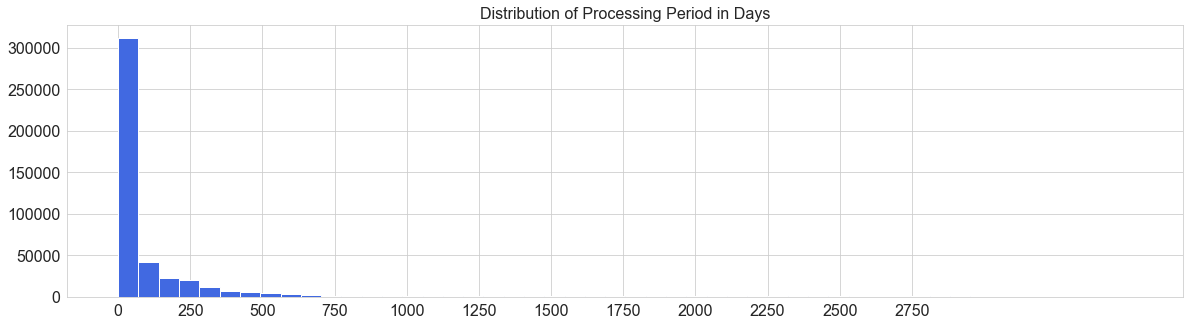

In [543]:
plt.figure(figsize = (20,5))
plt.hist(df.processing_period_days, bins = 50, color = 'royalblue')
plt.xticks(range(0, 3000, 250), fontsize = 16)
plt.yticks(fontsize = 16)
plt.title('Distribution of Processing Period in Days', fontsize = 16)
plt.show()
plt.savefig('Distribution of Processing Period in Days.png')

Text(0.5, 1.0, 'Number of requests by processing period')

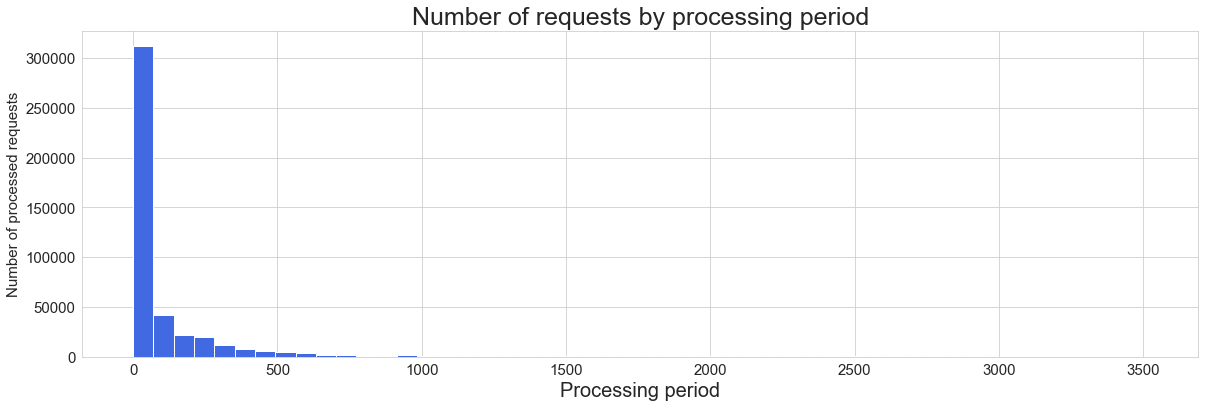

In [718]:
df.processing_period_days.plot(kind='hist', 
                                   bins = 50,
                                   xlabel = 'Number of processed requests',
                                   ylabel = 'Processing period by category',
                                   title = 'Distribution of Processing Period Categories',
                                   figsize = (20,6),
                                   color = 'royalblue')

plt.xlabel('Processing period', fontsize = 20)
plt.xticks(rotation = 0, fontsize = 15)
plt.ylabel('Number of processed requests', fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Number of requests by processing period', fontsize = 25)

### Step 2 - Define a threshold for the categories.
I will begin with only two categories, and will see how the models are doing with it. 

In [703]:
print(f"The threshold that separates data in two categories is \
the average number of days it takes to close a request: \
{round(df['processing_period_days'].mean())} days.")

The threshold that separates data in two categories is the average number of days it takes to close a request: 153 days.


### Step 3: Create a new Feature - Target Variable

In [712]:
# First, create only two categories: processing period = over or under one year
df['categorical_processing_period'] = df['processing_period_days'].apply(lambda x: 'under_th' if x <= 153 else 'over_th')

In [546]:
df['categorical_processing_period'].value_counts()

under_th    358393
over_th      95720
Name: categorical_processing_period, dtype: int64

Text(0.5, 1.0, 'Number of requests by processing period categories')

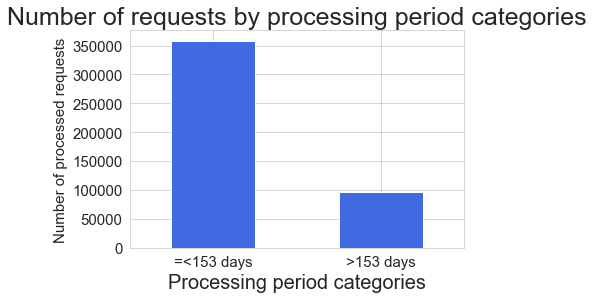

In [713]:
df['categorical_processing_period'].value_counts().plot(kind='bar', 
                                   xlabel = 'Number of processed requests',
                                   ylabel = 'Processing period by category',
                                   title = 'Distribution of Processing Period Categories',
                                   figsize = (6,4),
                                   color = 'royalblue')

plt.xlabel('Processing period categories', fontsize = 20)
plt.xticks(rotation = 0, fontsize = 15)
plt.ylabel('Number of processed requests', fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Number of requests by processing period categories', fontsize = 25)
#plt.savefig('Distribution of Processing Period Categories.png')

---
<center> End of Feature Engineering </center>

## Prepare the data for categorical models

### Step 1: Sample data

In [553]:
# I will be using computationally expensive models
# To save the runtime (or make it possible to fir a model) I will sample 20% of the data

fraction = df.sample(frac = .2, replace = False, random_state = 55)
fraction.shape

(90823, 73)

### Step 2: Establish Target and Dependent Variable

In [554]:
y_fraction = fraction['categorical_processing_period']
X_fraction = fraction.drop(columns=['processing_period_days', 'categorical_processing_period'])

### Step 3: Split the Data into Train/Validation/Test sets

In [555]:
X_train_fraction,\
X_val_fraction,\
X_test_fraction,\
y_train_fraction,\
y_val_fraction,\
y_test_fraction = train_val_test_split(X_fraction, y_fraction)

Train: 70%
Validation: 15%
Test: 15%


### Step 4: Scale the data

KNN doesn't assume a distribution for the data, therefore I need to scale the data for this model. 

My data is both non-normally distributed AND has quite a few outliers.

MinMax Scaler would be the best to keep the original distribution in place.
Robust Scaler helps reduce the impact of outliers but does not remove it completely.

**Becasue I am not removing the outliers, I am going to use a different scaler that takes the outliers into consideration**



In [556]:
from sklearn.preprocessing import RobustScaler

# instantiate the scaler
robust_scaler = RobustScaler()

# Transform both the X_train and X_test data with the fitted scaler
X_train_fraction_rob, X_val_fraction_rob, X_test_fraction_rob = scale_data(robust_scaler, X_train_fraction, X_val_fraction, X_test_fraction)

---
## Model 3: Logistic Regression
---

In [557]:
# grid search with logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression()


# removing penalty because l1 and elasticnet penalty don't work with the lbfgs solver
parameters = {
#     "penalty": ['l1', 'l2', 'elasticnet'],
    "class_weight": [None, 'balanced']
}

clf = GridSearchCV(logreg, parameters, verbose=3)
clf.fit(X_train_fraction_rob, y_train_fraction)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END .................class_weight=None;, score=0.872 total time=   0.5s
[CV 2/5] END .................class_weight=None;, score=0.876 total time=   0.4s
[CV 3/5] END .................class_weight=None;, score=0.873 total time=   0.5s
[CV 4/5] END .................class_weight=None;, score=0.875 total time=   0.5s
[CV 5/5] END .................class_weight=None;, score=0.871 total time=   0.4s
[CV 1/5] END .............class_weight=balanced;, score=0.817 total time=   0.5s
[CV 2/5] END .............class_weight=balanced;, score=0.826 total time=   0.5s
[CV 3/5] END .............class_weight=balanced;, score=0.824 total time=   0.5s
[CV 4/5] END .............class_weight=balanced;, score=0.827 total time=   0.5s
[CV 5/5] END .............class_weight=balanced;, score=0.821 total time=   0.5s


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'class_weight': [None, 'balanced']}, verbose=3)

In [558]:
# Find best parameters

params = [p['class_weight'] for p in clf.cv_results_['params']]
scores = clf.cv_results_['mean_test_score']

grid_search_df = pd.DataFrame(data=zip(params, scores),
                              columns=['class weight', 'score'])

grid_search_df.sort_values('score', ascending = False).head()

,class weight,score
0,None,0.873411
1,balanced,0.822842


In [559]:
# Instantiate
logreg = LogisticRegression(class_weight = None)

# Fit
logreg.fit(X_train_fraction_rob, y_train_fraction)

# Score
model_score(logreg, X_train_fraction_rob, X_val_fraction_rob, y_train_fraction, y_val_fraction)

Train Score 87.527%
Validation Score 88.014%


---
## Model 4: K-Nearest Neighbors
---

### Step 5: Find an optimal value for K in the KNN algorithm

In [560]:
from sklearn.neighbors import KNeighborsClassifier

# To reduce this cell's runtime, I have reduced the max number of neighbors
neighbors = range(1, 31, 3)


train_acc = []
val_acc = []

for n in neighbors:
    print(f"Training KNN model with {n} neighbors...")
    KNN_model = KNeighborsClassifier(n_neighbors=n)
    KNN_model.fit(X_train_fraction_rob, y_train_fraction)
    train_score = KNN_model.score(X_train_fraction_rob, y_train_fraction)
    val_score = KNN_model.score(X_val_fraction_rob, y_val_fraction)
    train_acc.append(train_score)
    val_acc.append(val_score)

Training KNN model with 1 neighbors...
Training KNN model with 4 neighbors...
Training KNN model with 7 neighbors...
Training KNN model with 10 neighbors...
Training KNN model with 13 neighbors...
Training KNN model with 16 neighbors...
Training KNN model with 19 neighbors...
Training KNN model with 22 neighbors...
Training KNN model with 25 neighbors...
Training KNN model with 28 neighbors...


In [561]:
# Index the value that is largest in the test accuracy
index_of_max = np.argmax(val_acc)
print(f"The largest value in the Validation accuracy: {max(val_acc)}")

# The corresponding best k value
best_k = neighbors[index_of_max]
print(f"The corresponding best k value: {best_k}")

The largest value in the Validation accuracy: 0.8936435701702877
The corresponding best k value: 16


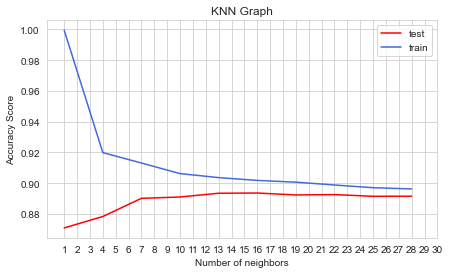

In [562]:
# Plot the graph
plt.figure(figsize=(7,4))
plt.plot(neighbors, val_acc, color="red", label="test")
plt.plot(neighbors, train_acc, color = "royalblue", label="train")
plt.ylabel("Accuracy Score")
plt.xlabel("Number of neighbors")
plt.xticks(range(1,31,1))
plt.title("KNN Graph")
plt.legend()
plt.show()

### Step 6: Fit the model

In [563]:
# Instantiate
KNN_model = KNeighborsClassifier(16)

# Fit
KNN_model.fit(X_train_fraction_rob, y_train_fraction)

# Score
print("Number of neighbors used:", KNN_model.n_neighbors)
model_score(KNN_model, X_train_fraction_rob, X_val_fraction_rob, y_train_fraction, y_val_fraction)

Number of neighbors used: 16
Train Score 90.185%
Validation Score 89.364%


**<center>End of Model 4: K-Nearest Neighbors</center>**

---
## Model 5: Decision Trees Classifier
---

### Step 1: GridSearch - Find an optimal parameters

In [564]:
from sklearn.tree import DecisionTreeClassifier

DT_model = DecisionTreeClassifier()

parameters = {
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': list(range(0, 20, 2)),
    'class_weight': [None, "balanced"]
}

clf = GridSearchCV(DT_model, parameters)
clf.fit(X_fraction, y_fraction)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]})

In [565]:
# Find best parameters

params = clf.cv_results_['params']
scores = clf.cv_results_['mean_test_score']

for i, param in enumerate(params):
    print(f"Score with {param}: {scores[i]}")

Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 0}: nan
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 2}: 0.8443675972284934
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 4}: 0.8694713814308184
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 6}: 0.878643066296355
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 8}: 0.8907985729675969
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 10}: 0.8922960077534391
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 12}: 0.893463095182026
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 14}: 0.8940356441688302
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 16}: 0.892659334140852
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 18}: 0.8900168553291227
Score with {'class_weight': None, 'criterion': 'entropy', 'max_depth': 0}: nan
Score with {'class_weigh

In [566]:
grid_search_df = pd.DataFrame(data=[params, scores]).T

In [567]:
grid_search_df.sort_values(1, ascending = False).head()

,0,1
27,"{'class_weight': None, 'criterion': 'log_loss'...",0.896403
17,"{'class_weight': None, 'criterion': 'entropy',...",0.89637
26,"{'class_weight': None, 'criterion': 'log_loss'...",0.895654
16,"{'class_weight': None, 'criterion': 'entropy',...",0.895621
18,"{'class_weight': None, 'criterion': 'entropy',...",0.895401


### Step 2: Fit the model with optimized parameters

In [568]:
# Instantiate
DT_model = DecisionTreeClassifier(class_weight = None, criterion = 'log_loss', max_depth = 14)

# Fit
DT_model.fit(X_train_fraction, y_train_fraction);

# Score
model_score(DT_model, X_train_fraction, X_val_fraction, y_train_fraction, y_val_fraction)

Train Score 91.862%
Validation Score 89.981%


Because I will be testing the models on robust scaled data in order to determine the best performing model, I will fit Decision Trees on a fitted data as well to compare the performance before comparing it to other models.

In [581]:
# Apply Optimized parameters to SCALED data to make sure there is no accuracy loss
DT_model = DecisionTreeClassifier(class_weight = None, criterion = 'log_loss', max_depth = 14)

# Fit
DT_model.fit(X_train_fraction_rob, y_train_fraction);

# Score
model_score(DT_model, X_train_fraction_rob, X_val_fraction_rob, y_train_fraction, y_val_fraction)

Train Score 91.866%
Validation Score 90.003%


In [570]:
%%timeit
DT_model.fit(X_train_fraction, y_train_fraction)

386 ms ± 3.13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [571]:
%%timeit
DT_model.fit(X_train_fraction_rob, y_train_fraction)

391 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Observation:**<br>
With scaled data Decision Tress model lost no accuracy, but performs slightly faster. This will be beneficial once I am fitting the model to the full size data set.

### Step 3:  Confusion Matrix for Decision Tree Classifier

In [572]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Get class predictions
y_pred = DT_model.predict(X_val_fraction)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_val_fraction, y_pred)

cf_matrix

array([[2124,  667],
       [1309, 9524]], dtype=int64)

In [573]:
# Label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted over_th", "Predicted Bad under_th"],
    index=["True over_th", "True under_th"]
)

display(cf_df)

,Predicted over_th,Predicted Bad under_th
True over_th,2124,667
True under_th,1309,9524


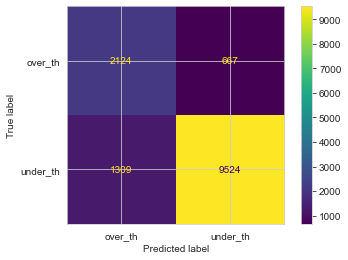

In [575]:
# The function expects the estimator, inputs and target as parameters
plot_confusion_matrix(DT_model, X_val_fraction, y_val_fraction);

In [576]:
# Select the False Positives from the confusion matrix
# True label 0 & predicted label 1
false_under_th = cf_matrix[0, 1]

print(f"{false_under_th} over_month were incorrectly predicted as under_th.")

667 over_month were incorrectly predicted as under_th.


In [577]:
# Select the FP from the confusion matrix
# True label 0 & predicted label 1
false_over_th = cf_matrix[1, 0]

print(f"{false_over_th} under_month were incorrectly predicted as over_th.")

1309 under_month were incorrectly predicted as over_th.


### Step 4: Precision and Recall

In [578]:
print(f"Precision: {round(cf_matrix[1,1]/cf_matrix[:,1].sum()*100,1)}%. \
Out of {cf_matrix[:,1].sum()} predicted under_th, {cf_matrix[1,1]} \
were predicted correctly.")
print(f"Recall: {round(cf_matrix[0,0]/cf_matrix[:,0].sum()*100, 1)}%. \
Out of {cf_matrix[:,0].sum()} predicted over_th, {cf_matrix[0,0]} \
were predicted correctly.")

Precision: 93.5%. Out of 10191 predicted under_th, 9524 were predicted correctly.
Recall: 61.9%. Out of 3433 predicted over_th, 2124 were predicted correctly.


**Observations:**<br>
I get best results when predicting processing period under threshold. This can be explained by the fact that the majority of my data points are in this category.
My model is mostly confused when predicting over the threshold category.

**<center> End of Model 5: Decision Trees Classifier </center>**

---

**<center> End of Categorical Models </center>**

---

# Determine the best model

Because I got significantly better results with Classfying models, I will investigate their performance further.

I will be using the scaled data full set, not a fraction to determine the best model. I am fitting on the test set, not validation.

In [582]:
# Print used categorical models to pass the same parameters to the model evaluation function
print(logreg)
print(KNN_model)
print(DT_model)

LogisticRegression()
KNeighborsClassifier(n_neighbors=16)
DecisionTreeClassifier(criterion='log_loss', max_depth=14)


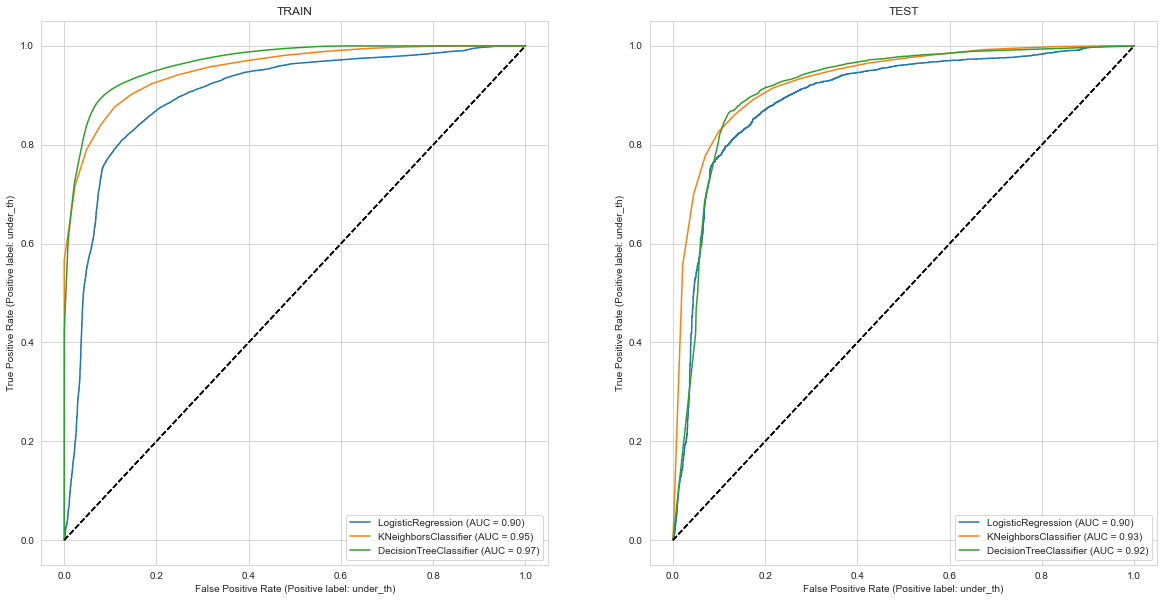

In [583]:
from sklearn.metrics import plot_roc_curve

# Create a list of model types - (instantiate)
model_list = [LogisticRegression(),
              KNeighborsClassifier(n_neighbors=16),
              DecisionTreeClassifier(class_weight = None, criterion = 'log_loss', max_depth = 14)]

# Create subplots
figs, axes = plt.subplots(1, 2, figsize=(20, 10))

# FOR each model
for model in model_list:

    # Fit
    model.fit(X_train_fraction_rob, y_train_fraction)

    # Plot ROC Curve for train & test
    plot_roc_curve(model, X_train_fraction_rob, y_train_fraction, ax=axes[0])
    plot_roc_curve(model, X_test_fraction_rob, y_test_fraction, ax=axes[1])
    
    # Add line y=x and titles
    for axis_num, plot_title in enumerate(['TRAIN', 'TEST']):
        axes[axis_num].plot([0,1], [0,1], color='black', linestyle='--')
        axes[axis_num].set_title(plot_title)
    

**Observations:**<br>
While Decision Trees slightly outperforms KNN on the Train set, KNN does better on the Test set with minimal difference. Logistic Regression also works well, and takes third place. 

**Next Steps:**<br>
Explore opportunities to improve the models and prediction strength. I will be using two models: KNN and Decision Trees.

Additionally I want to see if my Decision Trees are slightly overfitted. When I was looking for optimized parameters, I set a range of max_depth and the my step size was 2. I will try reducing the number of max_depth by 1 and see if it gets me a better result.

In [584]:
# Apply Optimized parameters to SCALED data to make sure there is no accuracy loss
DT_model = DecisionTreeClassifier(class_weight = None, criterion = 'log_loss', max_depth = 13)

# Fit
DT_model.fit(X_train_fraction_rob, y_train_fraction);

# Score
model_score(DT_model, X_train_fraction_rob, X_val_fraction_rob, y_train_fraction, y_val_fraction)

Train Score 91.181%
Validation Score 89.687%


No improvement. I will trust my optimized parameters then.

# Set variance threshold

I want to see if this will improve my scores even further.

In [585]:
df.var()

lat                                       14.948186
lon                                      134.966884
processing_period_days                153486.428495
year_2013                                  0.074459
year_2014                                  0.075421
                                          ...      
tags_Referred to Code Enforcement          0.000002
tags_Resolved                              0.240598
tags_Reviewed                              0.000048
tags_other                                 0.000511
tags_unknown                               0.236863
Length: 72, dtype: float64

In [586]:
# The scaler I am about to use can't convert string to float: 'under_th' 
# Convert my categorical variable into a binary variable

df['categorical_processing_period'] = df['processing_period_days'].apply(lambda x: 1 if x <=153 else 0)

In [587]:
# Scale the data using MinMax scaler (I tried robust, but that did not work well)
from sklearn.preprocessing import MinMaxScaler

mm_scaler = MinMaxScaler()
mm_data = mm_scaler.fit_transform(df)

var_thresh = pd.DataFrame(data=mm_data, columns=df.columns)

In [588]:
# Show the results
var_thresh.var()

lat                              0.016426
lon                              0.016612
processing_period_days           0.012423
year_2013                        0.074459
year_2014                        0.075421
                                   ...   
tags_Resolved                    0.240598
tags_Reviewed                    0.000048
tags_other                       0.000511
tags_unknown                     0.236863
categorical_processing_period    0.166355
Length: 73, dtype: float64

In [589]:
from sklearn.feature_selection import VarianceThreshold

# Instantiate the VarianceThresholder, we need to set a threshold variance
vt = VarianceThreshold(threshold=0.005)

# Fit to the data and calculate the variances per column
vt.fit(var_thresh)

VarianceThreshold(threshold=0.005)

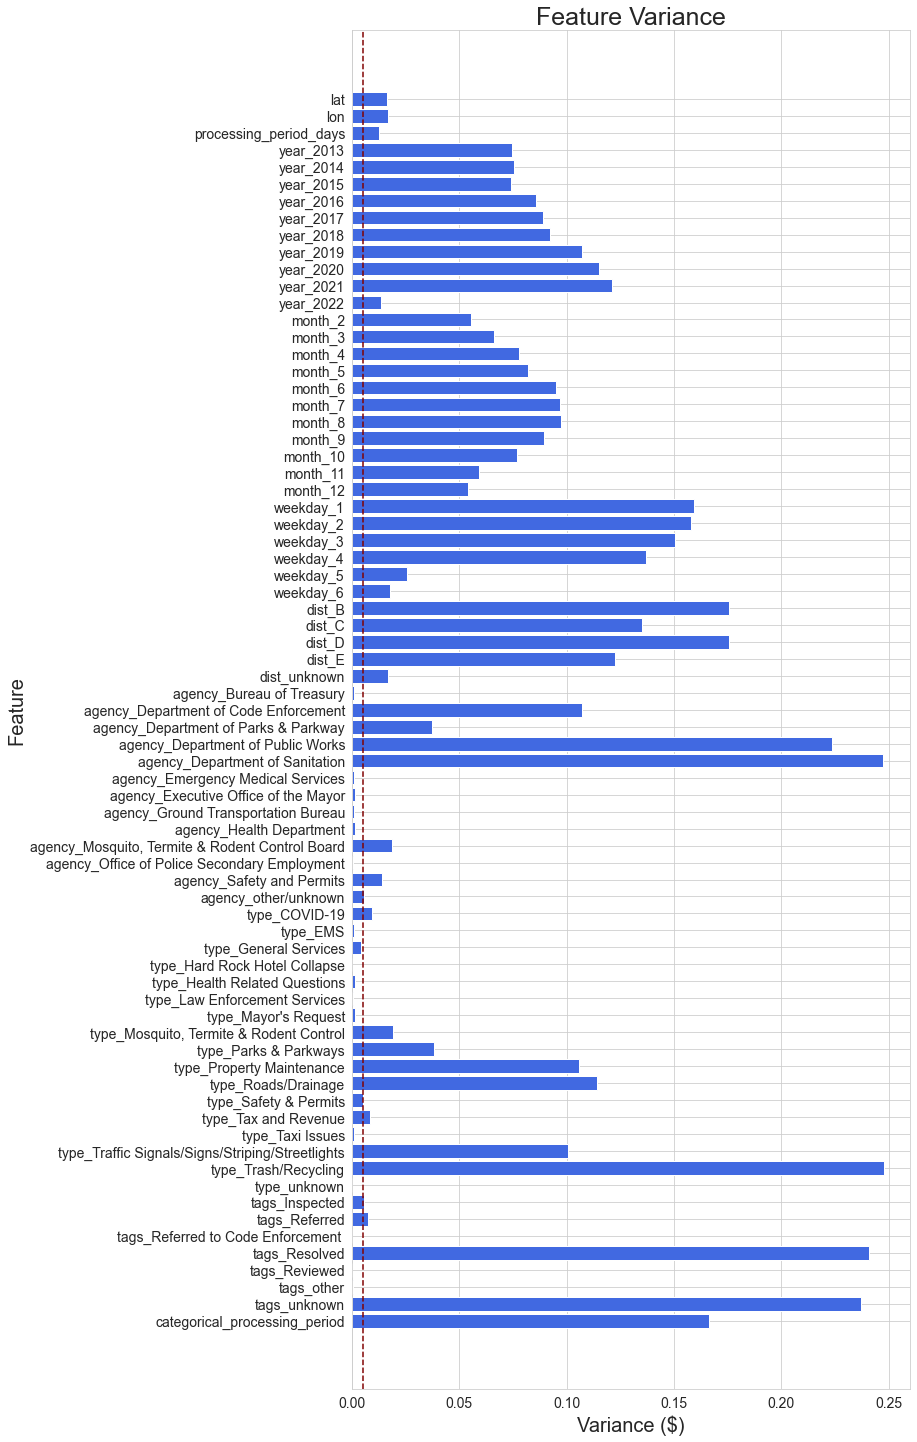

In [590]:
# Extract the variances per column
column_variances = vt.variances_

# Plot with the threshold
plt.figure(figsize = (10, 25))
plt.barh(np.flip(var_thresh.columns), np.flip(column_variances), color = 'royalblue')
plt.xlabel('Variance ($)', fontsize = 20)
plt.xticks(fontsize = 14)
plt.ylabel('Feature', fontsize = 20)
plt.yticks(fontsize = 14)
plt.axvline(0.005, color='maroon', linestyle='--')
plt.title('Feature Variance', fontsize = 25)
plt.show()

In [591]:
# Get the columns which are retained
vt.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True, False, False, False, False,  True,
       False,  True,  True,  True, False, False, False, False, False,
       False,  True,  True,  True,  True, False,  True, False,  True,
        True, False,  True,  True, False,  True, False, False,  True,
        True])

In [592]:
# Apply the variance threshold to drop columns below the given variance

var_thresh = pd.DataFrame(vt.transform(df), columns = df.columns[vt.get_support()])
var_thresh.head()

,lat,lon,processing_period_days,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,...,type_Property Maintenance,type_Roads/Drainage,type_Tax and Revenue,type_Traffic Signals/Signs/Striping/Streetlights,type_Trash/Recycling,tags_Inspected,tags_Referred,tags_Resolved,tags_unknown,categorical_processing_period
0,29.979937,-90.073291,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,29.968404,-90.034680,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,29.974061,-90.068478,91.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,29.967711,-90.095111,131.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.000000,0.000000,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [593]:
print(f"Number of columns removed: {df.shape[1] - var_thresh.shape[1]}")

Number of columns removed: 18


**Next steps:**
To see the effect of low-variance features removal, I would need to fit a model, but I then would have two conflicting scalers because I have already scaled the data using MinMax scaler. For the models I am using Robust scaler.<br>

Steps to resolve this conflict:<br>

1. Remove low-variance features from the initial df
2. Set X and y
3. Train-validation-test split
4. Apply Robust Scaler
5. Fit the models
6. Evaluate results

In [594]:
# Step 1 - Remove low-variance features from the initial df
# I will achieve this by creating a df_var based on the intial df
# and saving all features that we are NOT dropping into df_var

cols = df.columns[vt.get_support()]  # columns with high enough variance
df_var = df[cols]
df_var.shape

(454113, 55)

In [595]:
y_var = df_var['categorical_processing_period']
X_var = df_var.drop(columns = ['categorical_processing_period', 'processing_period_days'])

In [596]:
X_train_var,\
X_val_var,\
X_test_var,\
y_train_var,\
y_val_var,\
y_test_var = train_val_test_split(X_var, y_var)

Train: 70%
Validation: 15%
Test: 15%


In [597]:
# instantiate the scaler
robust_scaler = RobustScaler()

# Transform both the X_train and X_test data with the fitted scaler
X_train_var_rob, \
X_val_var_rob, \
X_test_var_rob = scale_data(robust_scaler, X_train_var, X_val_var, X_test_var)


In [598]:
# Instantiate
KNN_model = KNeighborsClassifier(n_neighbors = 16)

# Fit
KNN_model.fit(X_train_var_rob, y_train_var)

# Score
model_score(KNN_model, X_train_var_rob, X_val_var_rob, y_train_var, y_val_var)

Train Score 90.938%
Validation Score 89.561%


In [599]:
DT_model = DecisionTreeClassifier(class_weight = None, criterion = 'log_loss', max_depth = 14)

# Fit
DT_model.fit(X_train_var_rob, y_train_var)

# Score
model_score(DT_model, X_train_var_rob, X_val_var_rob, y_train_var, y_val_var)

Train Score 90.955%
Validation Score 90.011%


**Observations:**<br>
I don't see any improvement on the accuracy score, but we got the same results with less variables. Conclusion: keep those variables out, as they seem to make no significant difference. 

# Multicollinearity check

In [600]:
X_var.shape

(454113, 53)

In [601]:
# Check for collinearity: 

X_corr = X_var.corr()

In [604]:
corr_table = ((X_corr >= 0.7) & (X_corr < 1)).sum(axis=0).sort_values() # sum by rows

correlated_vars = corr_table[corr_table > 0].index

X_corr = X_corr[correlated_vars]

correlations = X_corr.filter(items=correlated_vars, axis=0)

correlations = correlations.mask(correlations == 1)

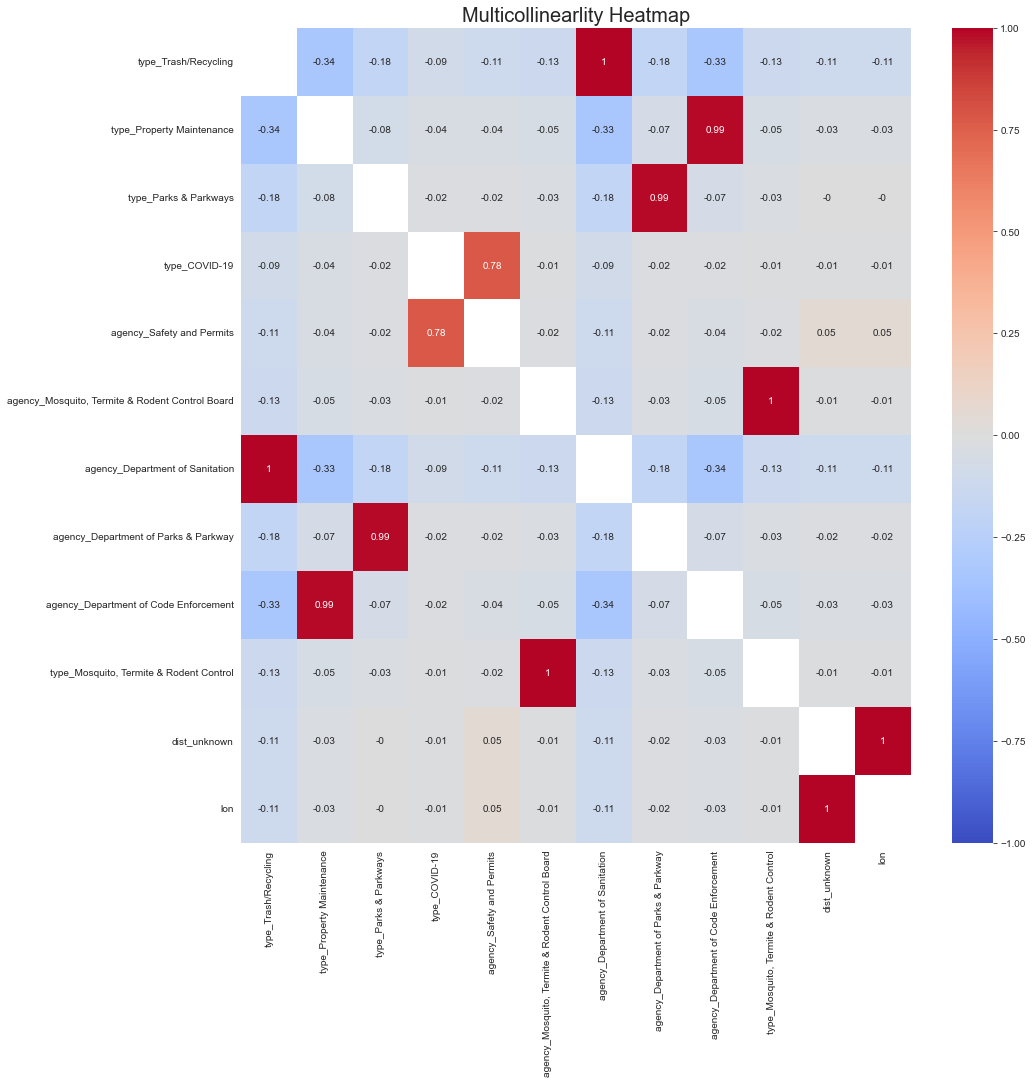

In [605]:
plt.figure(figsize=(15,15))
sns.heatmap(round(correlations,2), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm')
plt.title('Multicollinearlity Heatmap', fontsize = 20)
plt.show()

**Observations:**<br>

As determined during EDA in Part 2, there is a strong correlation between responsible agencies and request types. Because none of these variables are more important than the other in terms of my business question, I will randomly select agency to be removed.

**Next Steps:**<br>
1. Remove selected variables from the df rather than X
2. Set X  & y
3. Check for remaining multicolinearity over .5
4. Do a new train-validation-test split
5. Apply robust scaler
6. Fit models
7. Evaluate results

In [606]:
# Step 1: Remove selected variables from the df rather than X
agencies_cols = X_var.columns[X_var.columns.str.startswith("agency_")]

In [607]:
df_var.drop(columns = agencies_cols, inplace=True)

In [610]:
# Step 2: Set X  & y

# I am trying to name my variables so that I know where they were taken from without scroling up
# When I see ...var_corr, I should recognize
# that this is coming from a data set where low variance and highly correlated variables were removed

y_var_corr = df_var['categorical_processing_period']
X_var_corr = df_var.drop(columns = ['categorical_processing_period', 'processing_period_days'])

In [611]:
# Step 3: Check for remaining collinearity over .5

X_corr = X_var_corr.corr()

In [612]:
corr_table = ((X_corr >= 0.5) & (X_corr < 1)).sum(axis=0).sort_values() # sum by rows

correlated_vars = corr_table[corr_table > 0].index

X_corr = X_corr[correlated_vars]

correlations = X_corr.filter(items=correlated_vars, axis=0)

correlations = correlations.mask(correlations == 1)

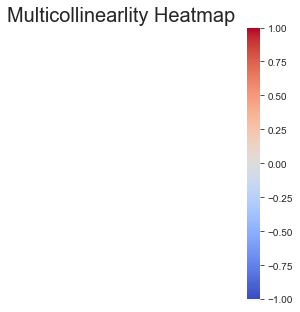

In [613]:
plt.figure(figsize=(5,5))
sns.heatmap(round(correlations,2), vmin=-1, vmax=1, center=0, annot=True, cmap='coolwarm')
plt.title('Multicollinearlity Heatmap', fontsize = 20)
plt.show()

In [608]:
df_var.drop(columns = ['dist_unknown', 'lon'], inplace=True)

In [609]:
df_var.shape

(454113, 46)

In [614]:
# Step 4: Train-validation-test split

X_train_var_corr,\
X_val_var_corr,\
X_test_var_corr,\
y_train_var_corr,\
y_val_var_corr,\
y_test_var_corr = train_val_test_split(X_var_corr, y_var_corr)

Train: 70%
Validation: 15%
Test: 15%


In [616]:
# Step 5: Apply robust scaler

# Instantiate the scaler
robust_scaler = RobustScaler()

# Transform both the X_train and X_test data with the fitted scaler
X_train_var_corr_rob, \
X_val_var_corr_rob, \
X_test_var_corr_rob = scale_data(robust_scaler, X_train_var_corr, X_val_var_corr, X_test_var_corr)


In [618]:
# Instantiate
KNN_model = KNeighborsClassifier(n_neighbors = 16)

# Fit
KNN_model.fit(X_train_var_corr_rob, y_train_var_corr)

# Score
model_score(KNN_model, X_train_var_corr_rob, X_val_var_corr_rob, y_train_var_corr, y_val_var_corr)

Train Score 90.892%
Validation Score 89.674%


In [619]:
DT_model = DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 14)

# Fit
DT_model.fit(X_train_var_corr_rob, y_train_var_corr)

# Score
model_score(DT_model, X_train_var_corr_rob, X_val_var_corr_rob, y_train_var_corr, y_val_var_corr)

Train Score 90.943%
Validation Score 90.073%


**Observation:**<br>
Once again, I observe no accuracy loss with less variables. I am moving on and keeping those variables out of the working data set.

# Clustering

So far I had been working with only two categories centered around the mean - 153 days.
The two categories separated the data based on `processing_period_days` under and over 153 days.
I tested 5 different models. Linear models performed expectedly worse than the categorical. 
I found my best model and reduced the number of variables with no loss in accuracy score on a full test set (as opposed to a 20% fraction). I tested the two best models on unsampled and downsampled data to even out data distribution between the categories.

Now I know which are the best tools to use, I will try to break down the data into a few more categories, and fit my best models on that data.

In [620]:
# How many different period lengths are there in my data?

df['processing_period_days'].value_counts()

0.0       46985
1.0       20388
7.0       14796
2.0       14475
3.0       13863
          ...  
1065.0        1
1295.0        1
1674.0        1
1598.0        1
2246.0        1
Name: processing_period_days, Length: 2575, dtype: int64

In [625]:
print(f"There are {len(df['processing_period_days'].value_counts())} diferent period lengths is the in my data.")

There are 2575 diferent period lengths is the in my data.


In [626]:
# Save all period lengths to a df
period_table = df['processing_period_days'].value_counts()

In [627]:
# Show outliers
unique_cases = period_table[period_table == 1].index

In [628]:
# Show outliers min/max values
unique_cases.min(), unique_cases.max()

(796.0, 3515.0)

In [629]:
# Show median - the middle number in the list of all periods
np.median(df['processing_period_days'])

21.0

In [630]:
# Show 90, 95, and 99 percentile of all periods
np.percentile(df['processing_period_days'], q=[90, 95, 99])

array([ 353.,  650., 2358.])

**Observation:**<br>
90% of the data is under 353 days. I will round it up to a year and investigate further.

## Inspect inliers (periods < 365 days)

In [631]:
# Create a category that will break down the data into two new categories
df['category'] = 'under a year'
df.loc[df['processing_period_days'] > 365, 'category'] = 'over a year'

In [632]:
df['category'].value_counts()

under a year    410138
over a year      43975
Name: category, dtype: int64

In [633]:
# Save data `under_year` into its own df to investigate further
under_year = df[df['category'] == 'under a year']

In [634]:
# Check
under_year['processing_period_days'].min(), under_year['processing_period_days'].max()

(0.0, 365.0)

In [635]:
# Break it down into categories by month
# Note: my calculation is based on 30 day months

month_count = 1
for i in list(range(0, 360, 30)):
    print(i, i + 30)
    n_months = df['processing_period_days'].between(i, i + 30)
    df.loc[n_months, 'category'] = str(month_count) + " months"
    month_count += 1

df.loc[df['processing_period_days'].between(330, 365), 'category'] = '12 months'

0 30
30 60
60 90
90 120
120 150
150 180
180 210
210 240
240 270
270 300
300 330
330 360


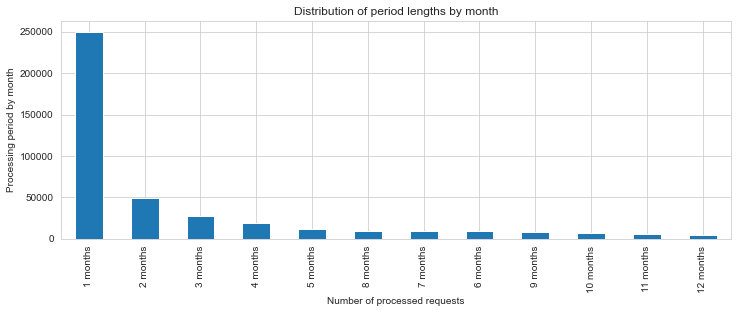

In [463]:
# Visualize distribution of period lengths by month

df['category'].value_counts().plot(kind='bar', 
                                   xlabel = 'Number of processed requests',
                                   ylabel = 'Processing period by month',
                                   title = 'Distribution of period lengths by month',
                                   figsize = (12,4))
plt.savefig('Distribution of period lengths by month.png')

## Category4

In [636]:
df_var['category4'] = ''
df_var.loc[df_var['processing_period_days'].between(0, 30), 'category4'] = 'under a month'
df_var.loc[df_var['processing_period_days'].between(30, 153), 'category4'] = '1-6 months'
df_var.loc[df_var['processing_period_days'].between(154,365), 'category4'] = '6-12 months'
df_var.loc[df_var['processing_period_days'] > 365, 'category4'] = 'over 12 months'

In [637]:
df_var['category4'].value_counts()

under a month     250472
1-6 months        107921
6-12 months        51745
over 12 months     43975
Name: category4, dtype: int64

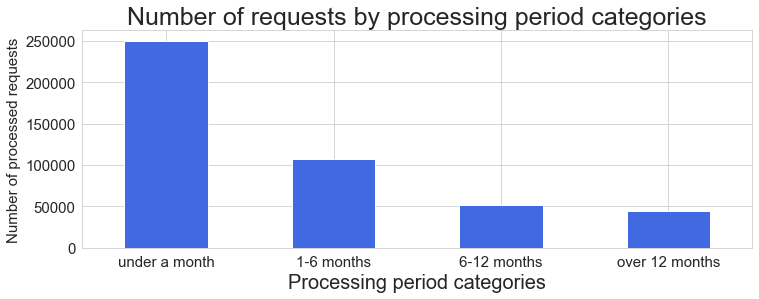

In [710]:
df_var['category4'].value_counts().plot(kind='bar', 
                                   xlabel = 'Number of processed requests',
                                   ylabel = 'Processing period by category',
                                   title = 'Distribution of period lengths by 4 categories',
                                   figsize = (12,4),
                                   color = 'royalblue')
plt.xlabel('Processing period categories', fontsize = 20)
plt.xticks(rotation = 0, fontsize = 15)
plt.ylabel('Number of processed requests', fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Number of requests by processing period categories', fontsize = 25)
plt.savefig('Distribution of period lengths by 4 categories.png')

# Fit the model on the data with 4 categories

Since I have a new target variable, i would like to check my hyperparameters to see if there are any changes. To make this possible, I have to work with a fraction of my full dataset once again.

In [638]:
df_var_frac = df_var.sample(frac = .25, replace = False, random_state = 55)

In [639]:
df_var_frac.shape

(113528, 47)

In [640]:
# To remind what columns I have left:
df_var_frac.columns

Index(['lat', 'processing_period_days', 'year_2013', 'year_2014', 'year_2015',
       'year_2016', 'year_2017', 'year_2018', 'year_2019', 'year_2020',
       'year_2021', 'year_2022', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'dist_B', 'dist_C', 'dist_D', 'dist_E',
       'type_COVID-19', 'type_Mosquito, Termite & Rodent Control',
       'type_Parks & Parkways', 'type_Property Maintenance',
       'type_Roads/Drainage', 'type_Tax and Revenue',
       'type_Traffic Signals/Signs/Striping/Streetlights',
       'type_Trash/Recycling', 'tags_Inspected', 'tags_Referred',
       'tags_Resolved', 'tags_unknown', 'categorical_processing_period',
       'category4'],
      dtype='object')

In [641]:
# Set y and X

y_4cats = df_var_frac['category4']
X_4cats = df_var_frac.drop(columns = ['processing_period_days', 'categorical_processing_period', 'category4'])

In [642]:
# train-validation-test split

X_train_4cats,\
X_val_4cats,\
X_test_4cats,\
y_train_4cats,\
y_val_4cats,\
y_test_4cats = train_val_test_split(X_4cats, y_4cats)

Train: 70%
Validation: 15%
Test: 15%


In [643]:
# Step 5: Apply robust scaler

# instantiate the scaler
robust_scaler = RobustScaler()

# Transform both the X_train and X_test data with the fitted scaler
X_train_4cats_rob, \
X_val_4cats_rob, \
X_test_4cats_rob = scale_data(robust_scaler, X_train_4cats, X_val_4cats, X_test_4cats)


### KNN  - 4 categories

In [644]:
# Find an optimal value for K in the KNN algorithm

neighbors = range(1, 26, 3)

train_acc = []
val_acc = []

for n in neighbors:
    print(f"Training KNN model with {n} neighbors...")
    KNN_model = KNeighborsClassifier(n_neighbors=n)
    KNN_model.fit(X_train_4cats_rob, y_train_4cats)
    train_score = KNN_model.score(X_train_4cats_rob, y_train_4cats)
    val_score = KNN_model.score(X_val_4cats_rob, y_val_4cats)
    train_acc.append(train_score)
    val_acc.append(val_score)

Training KNN model with 1 neighbors...
Training KNN model with 4 neighbors...
Training KNN model with 7 neighbors...
Training KNN model with 10 neighbors...
Training KNN model with 13 neighbors...
Training KNN model with 16 neighbors...
Training KNN model with 19 neighbors...
Training KNN model with 22 neighbors...
Training KNN model with 25 neighbors...


In [645]:
# Index the value that is largest in the test accuracy
index_of_max = np.argmax(val_acc)
print(f"The largest value in the Validation accuracy: {max(val_acc)}")

# The corresponding best k value
best_k = neighbors[index_of_max]
print(f"The corresponding best k value: {best_k}")

The largest value in the Validation accuracy: 0.7067527891955373
The corresponding best k value: 19


In [646]:
# Instantiate
KNN_model = KNeighborsClassifier(n_neighbors = 19)

# Fit
KNN_model.fit(X_train_4cats_rob, y_train_4cats)

# Score
model_score(KNN_model, X_train_4cats_rob, X_val_4cats_rob, y_train_4cats, y_val_4cats)

Train Score 73.736%
Validation Score 70.675%


## Decision Trees - 4 categories

In [647]:
# Find best parameters

DT_model = DecisionTreeClassifier()

parameters = {
    'criterion': ["gini", "entropy", "log_loss"],
    'max_depth': list(range(0, 20, 2)),
    'class_weight': [None, "balanced"]
}

clf = GridSearchCV(DT_model, parameters)
clf.fit(X_4cats, y_4cats)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]})

In [648]:
# Find best parameters

params = clf.cv_results_['params']
scores = clf.cv_results_['mean_test_score']

for i, param in enumerate(params):
    print(f"Score with {param}: {scores[i]}")

Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 0}: nan
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 2}: 0.6150289053377127
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 4}: 0.637684108652499
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 6}: 0.6618455442803602
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 8}: 0.6839370525332743
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 10}: 0.700919648617576
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 12}: 0.7103886771248454
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 14}: 0.7188006980567725
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 16}: 0.7191265918535512
Score with {'class_weight': None, 'criterion': 'gini', 'max_depth': 18}: 0.714634323139363
Score with {'class_weight': None, 'criterion': 'entropy', 'max_depth': 0}: nan
Score with {'class_weigh

In [649]:
grid_search_df = pd.DataFrame(data=[params, scores]).T

In [650]:
grid_search_df.sort_values(1, ascending = False).head()

,0,1
8,"{'class_weight': None, 'criterion': 'gini', 'm...",0.719127
7,"{'class_weight': None, 'criterion': 'gini', 'm...",0.718801
28,"{'class_weight': None, 'criterion': 'log_loss'...",0.717841
18,"{'class_weight': None, 'criterion': 'entropy',...",0.717805
19,"{'class_weight': None, 'criterion': 'entropy',...",0.716167


In [651]:
# Instantiate
DT_model = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 16)

# Fit
DT_model.fit(X_train_4cats_rob, y_train_4cats)

# Score
model_score(DT_model, X_train_4cats_rob, X_val_4cats_rob, y_train_4cats, y_val_4cats)

Train Score 78.684%
Validation Score 71.556%



# SMOTE

The way my data is distributed may have a significant impact on the accuracy score. In an attempt to improve the accuracy score, I will first try downsampling the data, and then upsample it as well. Fit models, and check the results.

## Prepare Data

In [652]:
smote = df_var_frac.copy()

In [653]:
smote['category4'].value_counts()

under a month     62803
1-6 months        26942
6-12 months       12971
over 12 months    10812
Name: category4, dtype: int64

In [654]:
smote.drop(columns = ['processing_period_days', 'categorical_processing_period'], inplace = True)

In [655]:
smote.shape

(113528, 45)

In [656]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [657]:
from imblearn.over_sampling import SMOTE
from collections import Counter

## Downsampling

In [658]:
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids

In [659]:
undersampler = RandomUnderSampler(random_state=42)
# undersampler = ClusterCentroids() # cluster-based downsampling did not run even on 25% of all data
X_res, y_res = undersampler.fit_resample(X_4cats, y_4cats)

In [660]:
pd.Series(y_res).value_counts()

1-6 months        10812
6-12 months       10812
over 12 months    10812
under a month     10812
Name: category4, dtype: int64

In [661]:
X_train_downsample, X_val_downsample, y_train_downsample, y_val_downsample = train_test_split(
    X_res, y_res, test_size = 0.3, random_state=1)

In [662]:
# instantiate the scaler
robust_scaler = RobustScaler()

# Fit the scaler to the X_train data
robust_scaler = robust_scaler.fit(X_train_downsample)

# Transform both the X_train and X_test data with the fitted scaler
X_train_downsample_rob = robust_scaler.transform(X_train_downsample)
X_val_downsample_rob = robust_scaler.transform(X_val_downsample)

In [663]:
# My Best Model - KNN
# Instantiate
KNN_model = KNeighborsClassifier(n_neighbors = 19)

# Fit
KNN_model.fit(X_train_downsample_rob, y_train_downsample)

# Score
model_score(KNN_model, X_train_downsample_rob, X_val_downsample_rob, y_train_downsample, y_val_downsample)

Train Score 70.588%
Validation Score 66.667%


In [305]:
# My Second Best Model - Decision Trees Classifier

# Instantiate
DT_model = DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 16)

# Fit
DT_model.fit(X_train_downsample_rob, y_train_downsample)

# Score
model_score(DT_model, X_train_downsample_rob, X_val_downsample_rob, y_train_downsample, y_val_downsample)

Train Score 80.676%
Validation Score 68.532%


In [664]:
# Make sure that my initial y_cats remain uncganged
y_4cats.value_counts()

under a month     62803
1-6 months        26942
6-12 months       12971
over 12 months    10812
Name: category4, dtype: int64

## Upsampling

In [665]:
y_upsample = smote['category4']
X_upsample = smote.drop(columns = 'category4')

In [666]:
y_upsample.value_counts() # class distribution before upsampling

under a month     62803
1-6 months        26942
6-12 months       12971
over 12 months    10812
Name: category4, dtype: int64

In [667]:
oversampler = SMOTE(random_state=42)

In [668]:
X_res, y_res = oversampler.fit_resample(X_upsample, y_upsample)

In [669]:
pd.Series(y_res).value_counts()

under a month     62803
over 12 months    62803
6-12 months       62803
1-6 months        62803
Name: category4, dtype: int64

In [670]:
X_train_upsample, X_val_upsample, y_train_upsample, y_val_upsample = train_test_split(
    X_res, y_res, test_size = 0.3, random_state=1)

With the balanced data we can train and evaluate our model. 

In [671]:
# Step 5: Apply robust scaler

# Instantiate the scaler
robust_scaler = RobustScaler()

# Transform both the X_train and X_test data with the fitted scaler
X_train_upsample_rob, \
X_val_upsample_rob, \
X_test_upsample_rob = scale_data(robust_scaler, X_train_upsample, X_val_upsample, X_test_upsample)


In [672]:
# My Best Model - KNN

# Instantiate
KNN_model = KNeighborsClassifier(n_neighbors = 19)

# Fit
KNN_model.fit(X_train_upsample_rob, y_train_upsample)

# Score
model_score(KNN_model, X_train_upsample_rob, X_val_upsample_rob, y_train_upsample, y_val_upsample)

Train Score 78.218%
Validation Score 75.740%


In [673]:
# My Second Best Model - Decision Trees Classifier

# Instantiate
DT_model = DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 14)

# Fit
DT_model.fit(X_train_upsample_rob, y_train_upsample)

# Score
model_score(DT_model, X_train_upsample_rob, X_val_upsample_rob, y_train_upsample, y_val_upsample)

Train Score 75.588%
Validation Score 73.637%


# Final Scoring

So far the best results were achieved by the following means:

Data: 25% sample of the full data set, Upsampled

Scaler: Roubust

Model: KNN

Number of categories: 4

Highest score: 75.740 % (Validation Score)

For the final scoring I will apply the same tool to the full size data set and fit the model to test set

In [674]:
df_var.shape

(454113, 47)

In [675]:
# X & y
y = df_var['category4']
X = df_var.drop(columns = ['category4'])

In [676]:
y.value_counts()

under a month     250472
1-6 months        107921
6-12 months        51745
over 12 months     43975
Name: category4, dtype: int64

In [677]:
# Upsample

oversampler = SMOTE(random_state=42)

In [678]:
X_res, y_res = oversampler.fit_resample(X, y)

In [679]:
pd.Series(y_res).value_counts()

1-6 months        250472
under a month     250472
6-12 months       250472
over 12 months    250472
Name: category4, dtype: int64

In [681]:
# Split
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

Train: 70%
Validation: 15%
Test: 15%


In [682]:
# Scale
robust_scaler = RobustScaler()

# Transform both the X_train and X_test data with the fitted scaler
X_train_rob, \
X_val_rob, \
X_test_rob = scale_data(robust_scaler, X_train, X_val, X_test)


In [683]:
# My Best Model - KNN - TEST Set - robust scaled

# Instantiate
KNN_model = KNeighborsClassifier(n_neighbors = 19)

# Fit
KNN_model.fit(X_train_rob, y_train)

# Score
print(f'Train Score: {KNN_model.score(X_train_rob, y_train):.3%}')
print(f'Validation Score: {KNN_model.score(X_val_rob, y_val):.3%}')
print(f'Test Score: {KNN_model.score(X_test_rob, y_test):.3%}')

Train Score: 92.319%
Validation Score: 91.352%
Test Score: 91.206%


## Inspect Outliers

In [322]:
over_year = df[df['category4'] == 'over 12 months']

In [323]:
type_cols = over_year.columns[over_year.columns.str.startswith('type_')]

In [324]:
type_cols

Index(['type_COVID-19', 'type_EMS', 'type_General Services',
       'type_Hard Rock Hotel Collapse', 'type_Health Related Questions',
       'type_Law Enforcement Services', 'type_Mayor's Request',
       'type_Mosquito, Termite & Rodent Control', 'type_Parks & Parkways',
       'type_Property Maintenance', 'type_Roads/Drainage',
       'type_Safety & Permits', 'type_Tax and Revenue', 'type_Taxi Issues',
       'type_Traffic Signals/Signs/Striping/Streetlights',
       'type_Trash/Recycling', 'type_unknown'],
      dtype='object')

In [325]:
agg_dict = dict.fromkeys(type_cols, 'sum')

In [329]:
by_category = df.groupby('category4').agg(agg_dict).T

In [330]:
by_category

category4,1-6 months,6-12 months,over 12 months,under a month
type_COVID-19,365,2,0,3969
type_EMS,74,98,0,183
type_General Services,100,17,6,1785
type_Hard Rock Hotel Collapse,10,19,0,0
type_Health Related Questions,144,139,4,347
type_Law Enforcement Services,31,31,53,25
type_Mayor's Request,112,129,22,275
"type_Mosquito, Termite & Rodent Control",732,657,63,7286
type_Parks & Parkways,2408,2929,4317,8402
type_Property Maintenance,4300,2713,2343,45327


## Statistical Test for Significance
## chi-square test:

**Null hypothesis: for each type, we expect the same number requests by category**

In [331]:
from scipy.stats import chisquare

In [334]:
pi_value = []
for i, row in by_category.iterrows():
    f_exp = [row.sum()/4] * 4 
    chi = chisquare(row.to_list(), f_exp)
    pi_value.append(chi.pvalue)

In [335]:
by_category['p-value'] = pi_value

In [336]:
by_category[by_category['p-value'] < 0.05]

category4,1-6 months,6-12 months,over 12 months,under a month,p-value
type_COVID-19,365,2,0,3969,0.000000e+00
type_EMS,74,98,0,183,1.986958e-41
type_General Services,100,17,6,1785,0.000000e+00
type_Hard Rock Hotel Collapse,10,19,0,0,1.489858e-07
type_Health Related Questions,144,139,4,347,1.001983e-81
type_Law Enforcement Services,31,31,53,25,4.575224e-03
type_Mayor's Request,112,129,22,275,8.483319e-53
"type_Mosquito, Termite & Rodent Control",732,657,63,7286,0.000000e+00
type_Parks & Parkways,2408,2929,4317,8402,0.000000e+00
type_Property Maintenance,4300,2713,2343,45327,0.000000e+00


**Conclusion:**<br>
For the categories above we can reject null hypothesis: for each type of service request, there is a different number of requests by category. We cannot say there is a pattern in request types based on a category.

# K Means Clustering

In [356]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)

In [359]:
from sklearn.cluster import KMeans

# Initialize
kmeans = KMeans(n_clusters=4)

# Fit
clusters = kmeans.fit_predict(X_train)

In [360]:
pd.Series(clusters).value_counts()

2    261101
0     43344
3      7428
1      6006
dtype: int64

In [361]:
cluster_df = pd.DataFrame(data=[clusters, y_train]).T

In [362]:
from collections import Counter

In [363]:
cluster_df.groupby([1, 0]).size().to_frame()

0
1              0        
1-6 months     2   75289
6-12 months    0   25994
               2   10355
over 12 months 0   17350
               1    6006
               3    7428
under a month  2  175457

In [364]:
cluster_df.groupby([0, 1]).size().to_frame()

0
0 1                     
0 6-12 months      25994
  over 12 months   17350
1 over 12 months    6006
2 1-6 months       75289
  6-12 months      10355
  under a month   175457
3 over 12 months    7428

**Observation:**<br>
Category 'under a month' falls under only one cluster, which means it is the best defined category. This also explains why we had most success predicting this type processing period. This is because there is a concentration of most of our data points in this category. Category '1-6 months' is also doing pretty well - there is only one cluster even though there are less data points. Category of '6-12 months' got broken down between two clusters, and 'over 12 months' was broken down to more than 3 clusters, which is evidence of lower confidence level when predicting for those categories. 

# Summary

## Business Problem Solution

With 91% of confidence I can predict how long it will take to satisfy a request based on four categories:
1. under a month
2. 1-6 months
3. 6-12 months
4. over 12 months<br>

The models that are contained in this notebook can be built into your online request forms, and your clients will receive an estimate for their case resolution immediately after submission. 

In addition, the models can be used internally in order to plan and allocate resources. With this change in place, over time you may observe increased productivity and shorter processing periods.


### Additional findings

The data has many outliers, which means there is a fair amount of cases that take several years to be processed. I have determined the agencies that have the most number of outliers and compared the results to the number of requests they received overall. This information may be useful in order to determine which agencies have the most challenges and what can be done to improve their performance. 

Lasty, I have discovered that your current data set is missing 1,573 records that can be found in the archived data set (2012 - 2018). Those records are identified in the first part of this project. 

I have noticed that you had previously collected additional information about each service request, and this information was stored in column 'Reason'. At this point, this field is not functional on your online request form. I recommend that you activate this field, as it may be useful for future predictions, such as for request auto allocation to a responsible agency. 

## Additional Resources

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

http://www.sthda.com/english/articles/38-regression-model-validation/158-regression-model-accuracy-metrics-r-square-aic-bic-cp-and-more/

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

'Pandas 1.x Cookbook_ Practical recipes for scientific computing' by Matt Harrison, Theodore Petrou